# Car Price prediction
Предсказание стоимости автомобиля с помощью различных моделей ML и DL, используя различные типы данных.

## Part 1
- Наивная модель.
- EDA.
- ML модель (CatBoost).

## Libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

# For NLP
import nltk
from nltk.probability import FreqDist
from nltk import word_tokenize
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
import re

# For ML
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif


# Keras
import tensorflow as tf

# GPU memory
config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8))
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations


# Charts
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 12, 6

## Functions

In [2]:
# Метрика
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))


# Графики для категориальных признаков
def get_gr_cat(col):
    with sns.axes_style("darkgrid"):
        data[col].value_counts(ascending=True).plot(
            kind='barh', title=col, cmap='coolwarm');


# Графики для числовых признаков
def get_gr_num(col, bns=50, line=False):
    sns.set(style="darkgrid", palette="bright")
    plt.title(f'Распределение признака {col}', fontsize=14)
    sns.distplot(data[col], bins=bns, kde=line);


# Добавление признака в описание, для лучшего обучения NLP-модели
def to_description(col):
    data.description = data[col] + ' ' + data['description']

In [3]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Data
Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [4]:
train = pd.read_csv(r'data/train.csv')
test = pd.read_csv(r'data/test.csv')
sample_submission = pd.read_csv(r'data/sample_submission.csv')

## Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.

In [5]:
# split
data_train, data_test = train_test_split(
    train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [6]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

# оцениваем точность
print(
    f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


## EDA

In [7]:
train

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,седан,BMW,чёрный,Авто на бодром ходу. Все работает отлично. П...,3.0 LTR,272 N12,бензин,245000,2007,5ER,530xi 3.0 AT (272 л.с.) 4WD,4,599000.0,2007,1099980990,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый
1,седан,AUDI,серебристый,"Продажа от собственника, второй владелец, ПТС ...",2.8 LTR,204 N12,бензин,183000,2011,A6,2.8 CVT (204 л.с.),4,850000.0,2011,1095836906,SEDAN VARIATOR 2.8,вариатор,2 владельца,8 лет и 6 месяцев,Оригинал,передний,Левый
2,седан,MERCEDES,чёрный,Внимание! Только для клиентов AVILON Автомобил...,3.5 LTR,306 N12,бензин,122733,2009,E_KLASSE,350 3.5 AT (306 л.с.) 4WD,4,1325000.0,2013,1100195530,SEDAN AUTOMATIC 3.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый
3,седан,AUDI,белый,В комплекте зимние колёса. 27.07.2020 Замена п...,2.0 LTR,180 N12,бензин,151000,2011,A6,2.0 CVT (180 л.с.),4,815000.0,2011,1099880662,SEDAN VARIATOR 2.0,вариатор,3 или более,4 года и 9 месяцев,Оригинал,передний,Левый
4,лифтбек,AUDI,белый,"Отличный авто, 2011 года выпуска, кроме передн...",1.8 LTR,160 N12,бензин,140000,2007,A5,1.8 CVT (160 л.с.),5,810000.0,2011,1083244610,LIFTBACK VARIATOR 1.8,вариатор,3 или более,2 года и 9 месяцев,Оригинал,передний,Левый
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6677,седан,BMW,серый,Продаётся любимый автомобиль! За годы эксплуат...,2.0 LTR,150 N12,бензин,232777,2005,3ER,320i 2.0 AT (150 л.с.),4,550000.0,2006,1100036650,SEDAN AUTOMATIC 2.0,автоматическая,3 или более,NaN,Оригинал,задний,Левый
6678,седан,BMW,чёрный,Куплена у официального дилера в 2017 г. \n\nТр...,2.0 LTR,190 N12,дизель,33700,2013,5ER,520d 2.0d AT (190 л.с.),4,1900000.0,2016,1090506038,SEDAN AUTOMATIC 2.0,автоматическая,3 или более,2 года и 2 месяца,Оригинал,задний,Левый
6679,седан,BMW,белый,Торг на месте. Все работает. Сборка немецкая. ...,2.0 LTR,143 N12,бензин,200000,2008,3ER,318i 2.0 AT (143 л.с.),4,530000.0,2008,1095155628,SEDAN AUTOMATIC 2.0,автоматическая,3 или более,2 года и 2 месяца,Оригинал,задний,Левый
6680,седан,AUDI,чёрный,Автомобиль в отличном состоянии.\n3-из Авто в ...,3.0 LTR,310 N12,бензин,72000,2013,A8,Long 3.0 AT (310 л.с.) 4WD,4,1970000.0,2016,1099625256,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

Есть пропуски в признаках:

- Владельцы
- Владение

In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671 entries, 0 to 1670
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              1671 non-null   object
 1   brand                 1671 non-null   object
 2   color                 1671 non-null   object
 3   description           1671 non-null   object
 4   engineDisplacement    1671 non-null   object
 5   enginePower           1671 non-null   object
 6   fuelType              1671 non-null   object
 7   mileage               1671 non-null   int64 
 8   modelDate             1671 non-null   int64 
 9   model_info            1671 non-null   object
 10  name                  1671 non-null   object
 11  numberOfDoors         1671 non-null   int64 
 12  productionDate        1671 non-null   int64 
 13  sell_id               1671 non-null   int64 
 14  vehicleConfiguration  1671 non-null   object
 15  vehicleTransmission   1671 non-null   

- Признаки (за исключением целевого price) совпадают с train.
- Есть пропуски в признаке Владение.

**Объединим train и test для обработки признаков**

In [10]:
train['sample'] = 1  # помечаем где у нас трейн
test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями
test['price'] = 0

data = test.append(train, sort=False).reset_index(drop=True)  # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [11]:
data

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price
0,универсал 5 дв.,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3.0 LTR,220 N12,бензин,350000,1984,W124,300 3.0 AT (220 л.с.),5,1991,1099427284,WAGON_5_DOORS AUTOMATIC 3.0,автоматическая,3 или более,6 лет и 3 месяца,Оригинал,задний,Левый,0,0.0
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3.0 LTR,313 N12,дизель,15000,2011,6ER,640d xDrive 3.0d AT (313 л.с.) 4WD,2,2013,1096405886,COUPE AUTOMATIC 3.0,автоматическая,1 владелец,6 лет и 6 месяцев,Оригинал,полный,Левый,0,0.0
2,купе,BMW,пурпурный,"Машина тут продаётся не в первый раз, НО! Толь...",2.5 LTR,218 N12,бензин,166600,2005,3ER,325xi 2.5 AT (218 л.с.) 4WD,2,2008,1100195294,COUPE AUTOMATIC 2.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый,0,0.0
3,седан,BMW,белый,"Автомобиль в отличном состоянии, весь в родной...",2.0 LTR,136 N12,бензин,147000,2005,3ER,318i 2.0 AT (136 л.с.),4,2007,1099827282,SEDAN AUTOMATIC 2.0,автоматическая,2 владельца,NaN,Оригинал,задний,Левый,0,0.0
4,седан,BMW,чёрный,Немка! с бесключивым доступом и камерой заднег...,2.0 LTR,190 N12,дизель,24000,2016,5ER,520d xDrive 2.0d AT (190 л.с.) 4WD,4,2019,1100076198,SEDAN AUTOMATIC 2.0,автоматическая,1 владелец,NaN,Оригинал,полный,Левый,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8348,седан,BMW,серый,Продаётся любимый автомобиль! За годы эксплуат...,2.0 LTR,150 N12,бензин,232777,2005,3ER,320i 2.0 AT (150 л.с.),4,2006,1100036650,SEDAN AUTOMATIC 2.0,автоматическая,3 или более,NaN,Оригинал,задний,Левый,1,550000.0
8349,седан,BMW,чёрный,Куплена у официального дилера в 2017 г. \n\nТр...,2.0 LTR,190 N12,дизель,33700,2013,5ER,520d 2.0d AT (190 л.с.),4,2016,1090506038,SEDAN AUTOMATIC 2.0,автоматическая,3 или более,2 года и 2 месяца,Оригинал,задний,Левый,1,1900000.0
8350,седан,BMW,белый,Торг на месте. Все работает. Сборка немецкая. ...,2.0 LTR,143 N12,бензин,200000,2008,3ER,318i 2.0 AT (143 л.с.),4,2008,1095155628,SEDAN AUTOMATIC 2.0,автоматическая,3 или более,2 года и 2 месяца,Оригинал,задний,Левый,1,530000.0
8351,седан,AUDI,чёрный,Автомобиль в отличном состоянии.\n3-из Авто в ...,3.0 LTR,310 N12,бензин,72000,2013,A8,Long 3.0 AT (310 л.с.) 4WD,4,2016,1099625256,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый,1,1970000.0


## Обработка признаков
### bodyType - тип автомобиля
- Пропусков нет
- Категориальный признак

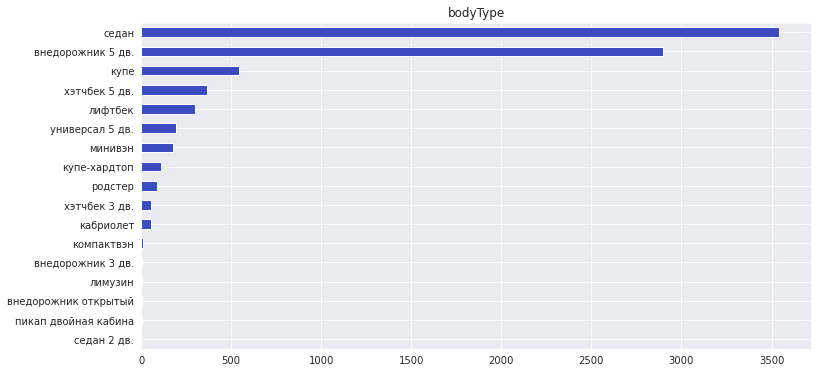

In [12]:
get_gr_cat('bodyType')

**Предварительный вывод:**
- Можно использовать для моделей после преобразования One-Hot Encoding.
- Добавим признак в описание, для более качественного обучения NLP-модели.

In [13]:
to_description('bodyType')
data.description

0       универсал 5 дв. Всем привет!\n\nПродам эксклюз...
1       купе Продаю любимейшую тачилу.. Обвес и тюнинг...
2       купе Машина тут продаётся не в первый раз, НО!...
3       седан Автомобиль в отличном состоянии, весь в ...
4       седан Немка! с бесключивым доступом и камерой ...
                              ...                        
8348    седан Продаётся любимый автомобиль! За годы эк...
8349    седан Куплена у официального дилера в 2017 г. ...
8350    седан Торг на месте. Все работает. Сборка неме...
8351    седан Автомобиль в отличном состоянии.\n3-из А...
8352    лимузин Удлиненный заводской Pullman на базе W...
Name: description, Length: 8353, dtype: object

### brand - Марка автомобиля

- Пропусков нет
- Категориальный признак

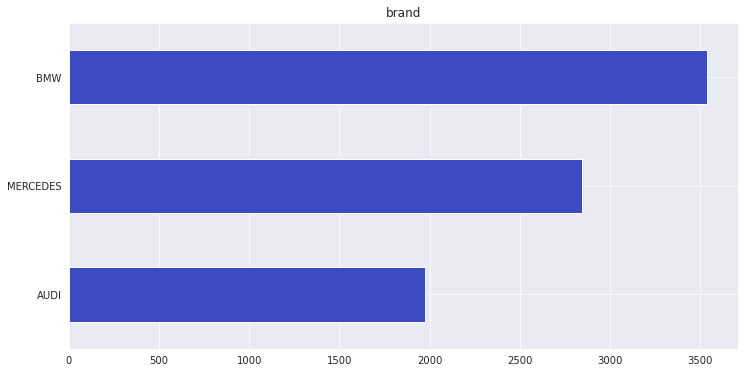

In [14]:
get_gr_cat('brand')

**Предварительный вывод:**
- В датасете 3 марки автомобилей.
- Можно использовать для моделей после преобразования One-Hot Encoding.
- Добавим признак в описание, для более качественного обучения NLP-модели.

In [15]:
to_description('brand')

### color - Цвет автомобиля
- Пропусков нет
- Категориальный признак

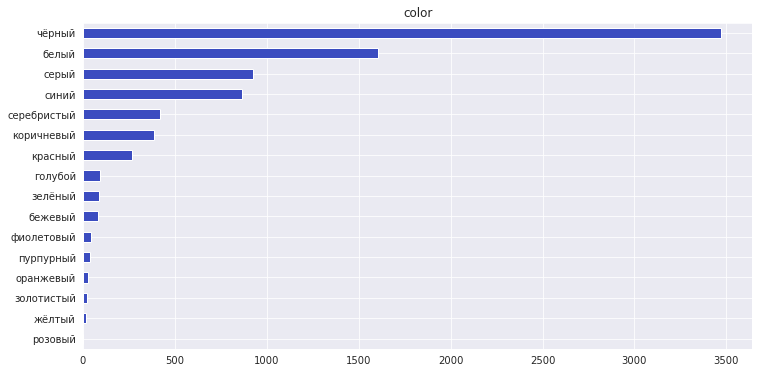

In [16]:
get_gr_cat('color')

**Предварительный вывод:**
- Можно использовать для моделей после преобразования One-Hot Encoding.
- Добавим признак в описание, для более качественного обучения NLP-модели.

In [17]:
to_description('color')

### description - Описание автомобиля
- Пропусков нет.
- Текстовое описание автомобилей.
- Будем использовать для NLP-модели.

### engineDisplacement - Объем двигателя
- Пропусков нет

In [18]:
data.engineDisplacement.unique()

array(['3.0 LTR', '2.5 LTR', '2.0 LTR', '3.5 LTR', '1.8 LTR', '2.2 LTR',
       '5.5 LTR', '4.8 LTR', '1.6 LTR', '4.7 LTR', '4.0 LTR', '1.5 LTR',
       '2.4 LTR', '1.4 LTR', '2.1 LTR', '5.2 LTR', '4.4 LTR', '2.8 LTR',
       '4.2 LTR', '3.2 LTR', '6.0 LTR', '3.7 LTR', '5.0 LTR', '1.2 LTR',
       '3.6 LTR', '2.3 LTR', '6.2 LTR', '1.7 LTR', '1.3 LTR', '5.4 LTR',
       '3.1 LTR', '2.6 LTR', '3.8 LTR', '4.1 LTR', '2.9 LTR', '6.6 LTR',
       '5.9 LTR', 'undefined LTR', '2.7 LTR', '0.7 LTR', '1.9 LTR',
       '4.3 LTR', '5.8 LTR', '4.9 LTR', '3.4 LTR', '6.3 LTR', '5.6 LTR',
       '4.6 LTR'], dtype=object)

Преобразуем в числовой формат

In [19]:
data.engineDisplacement = data.engineDisplacement.apply(
    lambda x: 0 if x == 'undefined LTR' else float(x.replace(' LTR', '')))

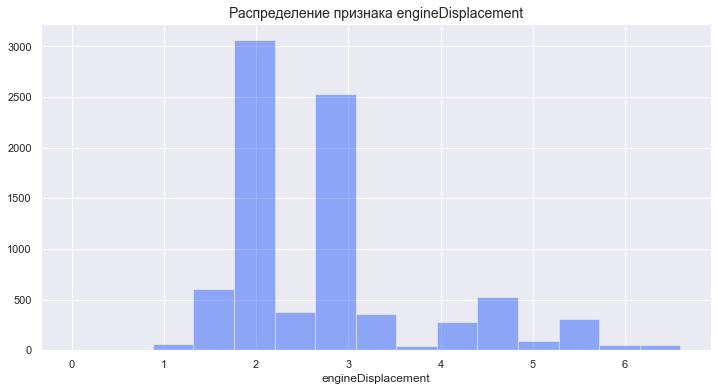

In [20]:
get_gr_num('engineDisplacement', 15)

**Предварительный вывод:**
- Получили числовой признак.
- Распределение не нормальное, потребуется нормализация признака.

### enginePower - мощность двигателя
- Пропусков нет.

In [21]:
data.enginePower.unique()

array(['220 N12', '313 N12', '218 N12', '136 N12', '190 N12', '340 N12',
       '245 N12', '316 N12', '170 N12', '160 N12', '231 N12', '388 N12',
       '180 N12', '367 N12', '115 N12', '184 N12', '177 N12', '455 N12',
       '422 N12', '163 N12', '249 N12', '272 N12', '224 N12', '122 N12',
       '557 N12', '333 N12', '306 N12', '156 N12', '150 N12', '264 N12',
       '450 N12', '555 N12', '407 N12', '130 N12', '400 N12', '204 N12',
       '469 N12', '192 N12', '210 N12', '211 N12', '239 N12', '200 N12',
       '350 N12', '420 N12', '300 N12', '381 N12', '265 N12', '258 N12',
       '390 N12', '197 N12', '120 N12', '544 N12', '193 N12', '235 N12',
       '233 N12', '394 N12', '355 N12', '421 N12', '320 N12', '585 N12',
       '105 N12', '280 N12', '194 N12', '132 N12', '639 N12', '250 N12',
       '335 N12', '510 N12', '116 N12', '360 N12', '238 N12', '225 N12',
       '625 N12', '571 N12', '507 N12', '286 N12', '372 N12', '575 N12',
       '408 N12', '310 N12', '354 N12', '255 N12', 

Преобразуем в числовой формат

In [22]:
data.enginePower = data.enginePower.apply(lambda x: int(x.replace(' N12', '')))

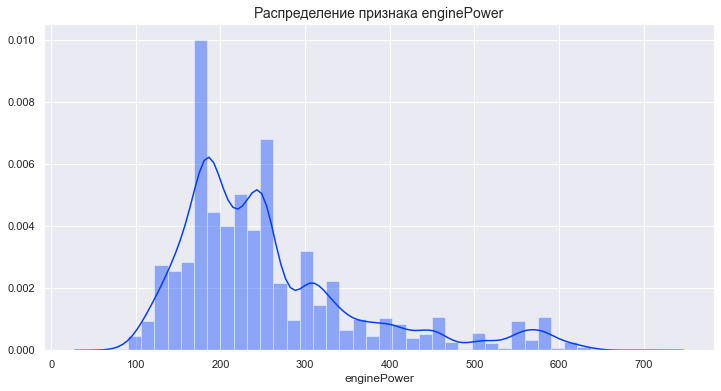

In [23]:
get_gr_num('enginePower', 40, 1)

**Предварительный вывод:**
- Получили числовой признак.
- Распределение не нормальное, потребуется нормализация признака.

### fuelType - тип топлива
- Пропусков нет.
- Категориальный признак.

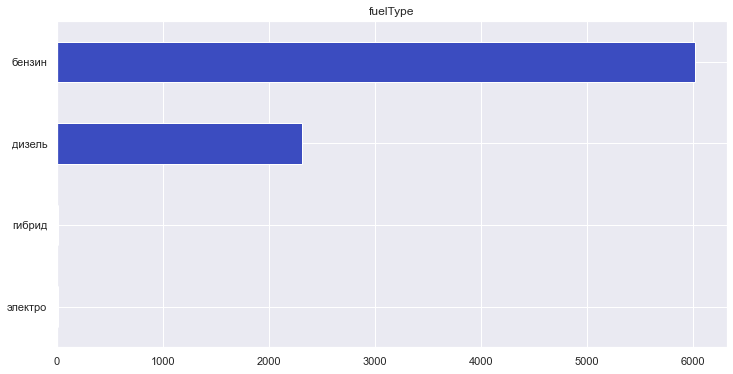

In [24]:
get_gr_cat('fuelType')

**Предварительный вывод:**
- Можно использовать для моделей после преобразования One-Hot Encoding.
- Добавим признак в описание, для более качественного обучения NLP-модели.

In [25]:
to_description('fuelType')

### mileage - Пробег автомобиля
- Пропусков нет.
- Числовой признак.

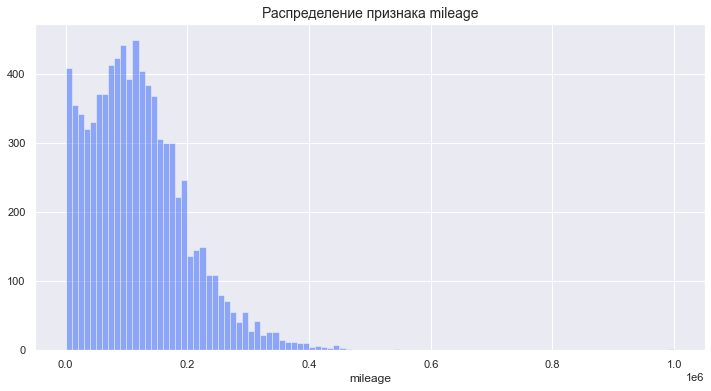

In [26]:
get_gr_num('mileage', 100)

**Предварительный вывод:**
- Потребуется нормализация признака.

### modelDate - Год модели
- Пропусков нет.
- Числовой признак.

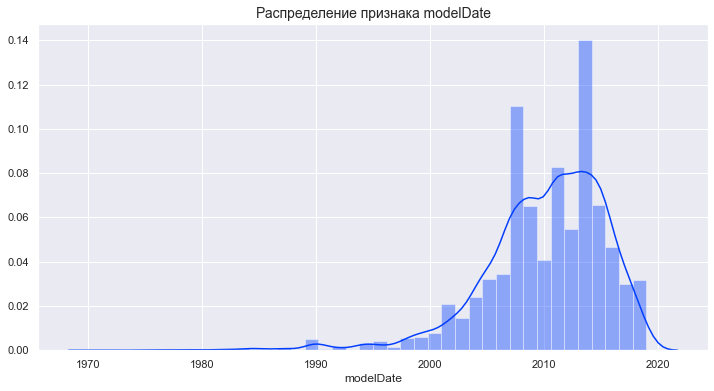

In [27]:
get_gr_num('modelDate', 40, 1)

**Предварительный вывод:**
- Потребуется нормализация признака.

### model_info - Модель автомобиля
- Пропусков нет.
- Категориальный признак.

In [28]:
data.model_info.unique()

array(['W124', '6ER', '3ER', '5ER', 'Q7', 'SL_KLASSE', 'A5', 'A4',
       'GL_KLASSE', 'A6', '1ER', 'X5', 'X3', 'S_KLASSE',
       'S_CLASS_MAYBACH', 'G_KLASSE', 'E_KLASSE', 'X7', 'Q5', 'A3',
       'B_KLASSE', '4', 'CLS_KLASSE_AMG', 'RS3', 'X6', 'C_KLASSE', 'X1',
       'S8', 'Q3', 'X6_M', '7ER', 'GLS_KLASSE', 'A7', 'GLC_KLASSE', 'TT',
       'Q8', 'M3', 'M4', 'C_KLASSE_AMG', 'X4', 'G_KLASSE_AMG', 'VITO',
       'M_KLASSE', 'CLA_KLASSE', 'TTS', 'GLK_KLASSE', 'SLK_KLASSE_AMG',
       'CLS_KLASSE', 'R_KLASSE', 'S_KLASSE_AMG', 'VIANO', 'GLE_KLASSE',
       'S5', 'AMG_GT', 'A8', 'M_KLASSE_AMG', 'A_KLASSE', 'M5', 'X5_M',
       'GLE_KLASSE_COUPE_AMG', 'ALLROAD', 'GLE_KLASSE_COUPE',
       'E_KLASSE_AMG', 'GLA_CLASS', 'SLS_AMG', 'AMG_GLC_COUPE',
       'V_KLASSE', 'GLE_KLASSE_AMG', 'X2', 'A4_ALLROAD', 'CL_KLASSE',
       'SLK_KLASSE', 'CLA_KLASSE_AMG', 'RS5', 'X_KLASSE', 'W123', 'A1',
       'S6', 'M6', 'M1', '2ER', '8ER', 'RS6', 'SL_KLASSE_AMG', 'S7', 'M2',
       'CL_KLASSE_AMG', 'Z4', 'X

**Предварительный вывод:**
- Можно использовать для моделей после преобразования One-Hot Encoding.
- Добавим признак в описание, для более качественного обучения NLP-модели.

In [29]:
to_description('model_info')

### name
- Признак содержит информацию о мощности и объеме двигателя, типе трансмиссии, а также другую вспомогательную информацию.
- Информация в данном признаке в основном дублируется другими признаками.
- Вытащим некоторую значимую информацию из признака и удалим его на этапе создания новых признаков.

### numberOfDoors - Количество дверей
- Пропусков нет.
- Числовой признак, но можно рассматривать его, как категориальный (4 варианта кузова автомобиля).

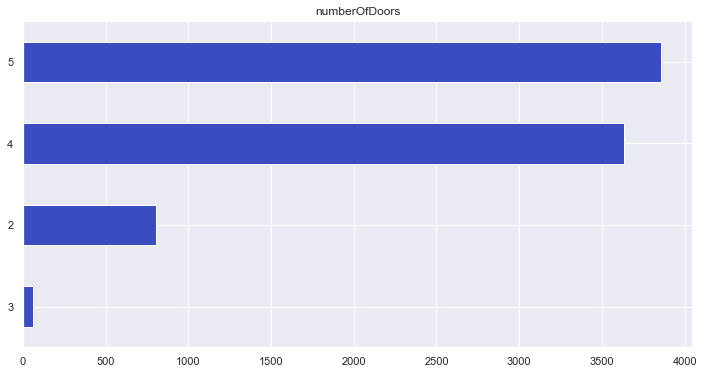

In [30]:
get_gr_cat('numberOfDoors')

**Предварительный вывод:**
- Можно использовать для моделей после преобразования One-Hot Encoding.

### productionDate - Год производства автомобиля
- Пропусков нет.
- Числовой признак.

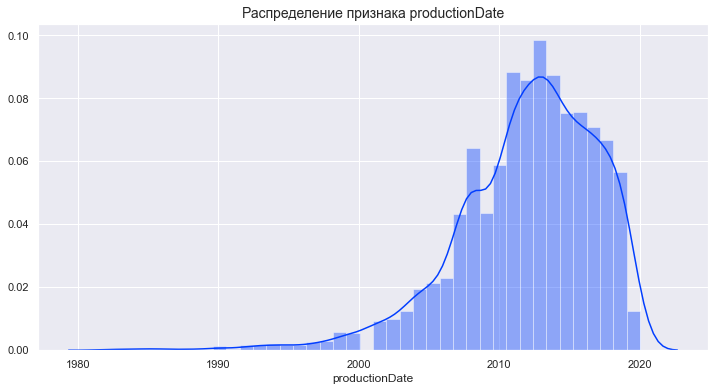

In [31]:
get_gr_num('productionDate', 40, 1)

**Предварительный вывод:**
- Потребуется нормализация признака.

### sell_id - ID объявления о продаже автомобиля
- Не несет никакой ценной информации, но используется для привязки изображений.

### vehicleConfiguration - Конфигурация автомобиля
- Признак содержит информацию о типе кузова, количестве дверей, типе трансмиссии и объеме двигателя автомобиля.
- Данная информация также содержится в других признаках.
- Признак можно удалять.

In [32]:
data = data.drop('vehicleConfiguration', axis=1)

### vehicleTransmission - Тип трансмиссии автомобиля
- Пропусков нет.
- Категориальный признак.

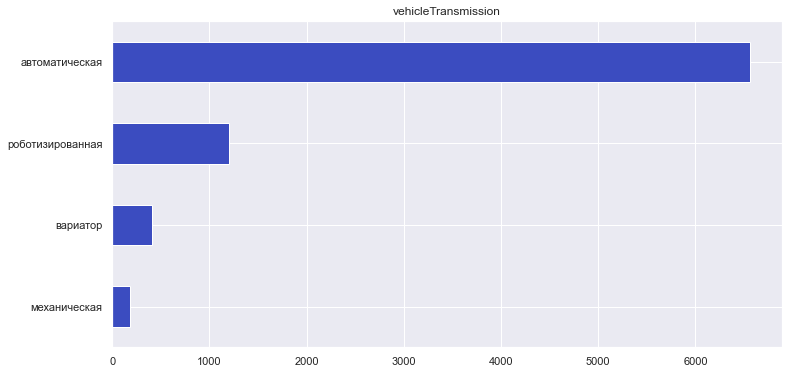

In [33]:
get_gr_cat('vehicleTransmission')

**Предварительный вывод:**
- Можно использовать для моделей после преобразования One-Hot Encoding.

### Владельцы - Количество владельцев автомобиля
- Есть пропуски.
- Категориальный признак.

In [34]:
data.Владельцы.unique()

array(['3 или более', '1\xa0владелец', '2\xa0владельца', nan],
      dtype=object)

- Заменим пропуски на 1-го владельца.
- Преобразуем в числовой формат, но признак будем считать категориальным.

In [35]:
data.Владельцы = data.Владельцы.fillna('1\xa0владелец')
change_dict = {
    '3 или более': 3,
    '1\xa0владелец': 1,
    '2\xa0владельца': 2
}
data.Владельцы = data.Владельцы.replace(to_replace=change_dict)

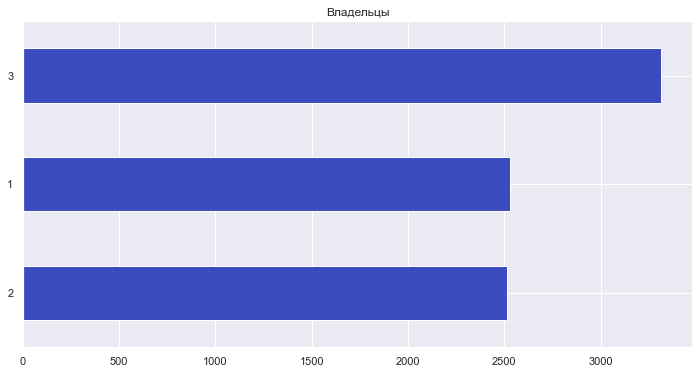

In [36]:
get_gr_cat('Владельцы')

**Предварительный вывод:**
- Преобразовали в удобный формат.
- Можно использовать для моделей после преобразования One-Hot Encoding.

### Владение - Срок владения автомобилем
- Очень много пропусков.
- Качественно восстановить пропущенные значения не реально, удаляем.

In [37]:
data = data.drop('Владение', axis=1)

### ПТС
- Пропусков нет.
- Категориальный признак.

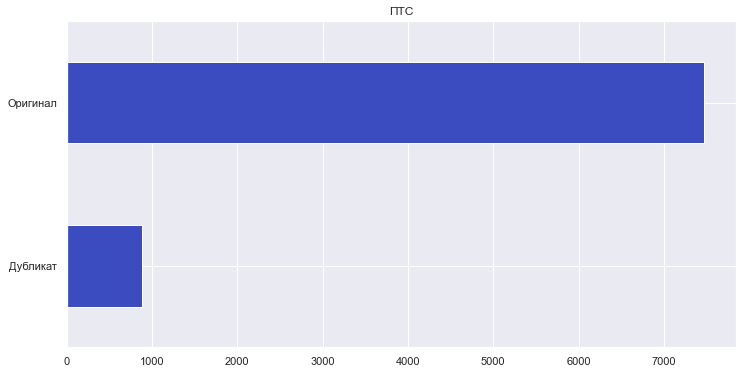

In [38]:
get_gr_cat('ПТС')

**Предварительный вывод:**
- Можно использовать для моделей после преобразования One-Hot Encoding.

### Привод
- Пропусков нет.
- Категориальный признак.

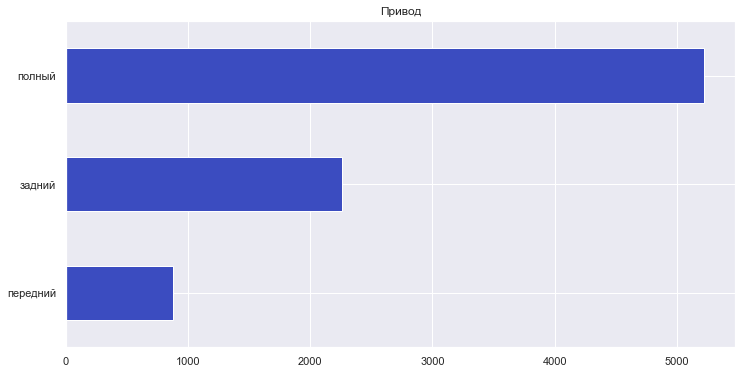

In [39]:
get_gr_cat('Привод')

**Предварительный вывод:**
- Можно использовать для моделей после преобразования One-Hot Encoding.
- Добавим признак в описание, для более качественного обучения NLP-модели.

In [40]:
to_description('Привод')

### Руль
- Пропусков нет.
- Категориальный признак.

In [41]:
data.Руль.value_counts()

Левый     8351
Правый       2
Name: Руль, dtype: int64

In [42]:
train.Руль.value_counts()

Левый     6680
Правый       2
Name: Руль, dtype: int64

- Всего 2 объявления на автомобили с правым рулем и оба в тренировочном датасете.
- Лучше всего удалить данные строки из обучающего датасета и удалить данный признак.

In [43]:
data = data[data.Руль != 'Правый']
data = data.drop('Руль', axis=1)

### price - Цена автомобиля (целевая переменная)

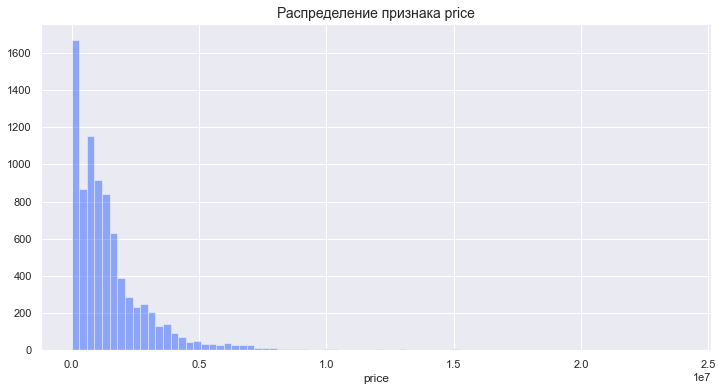

In [44]:
get_gr_num('price', 80)

**Предварительный вывод:**
- Нулевые значения в тестовом датасете.
- Потребуется нормализация признака.

## Создание новых признаков

In [45]:
data

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,productionDate,sell_id,vehicleTransmission,Владельцы,ПТС,Привод,sample,price
0,универсал 5 дв.,MERCEDES,чёрный,задний W124 бензин чёрный MERCEDES универсал 5...,3.0,220,бензин,350000,1984,W124,300 3.0 AT (220 л.с.),5,1991,1099427284,автоматическая,3,Оригинал,задний,0,0.0
1,купе,BMW,белый,полный 6ER дизель белый BMW купе Продаю любиме...,3.0,313,дизель,15000,2011,6ER,640d xDrive 3.0d AT (313 л.с.) 4WD,2,2013,1096405886,автоматическая,1,Оригинал,полный,0,0.0
2,купе,BMW,пурпурный,полный 3ER бензин пурпурный BMW купе Машина ту...,2.5,218,бензин,166600,2005,3ER,325xi 2.5 AT (218 л.с.) 4WD,2,2008,1100195294,автоматическая,3,Оригинал,полный,0,0.0
3,седан,BMW,белый,задний 3ER бензин белый BMW седан Автомобиль в...,2.0,136,бензин,147000,2005,3ER,318i 2.0 AT (136 л.с.),4,2007,1099827282,автоматическая,2,Оригинал,задний,0,0.0
4,седан,BMW,чёрный,полный 5ER дизель чёрный BMW седан Немка! с бе...,2.0,190,дизель,24000,2016,5ER,520d xDrive 2.0d AT (190 л.с.) 4WD,4,2019,1100076198,автоматическая,1,Оригинал,полный,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8348,седан,BMW,серый,задний 3ER бензин серый BMW седан Продаётся лю...,2.0,150,бензин,232777,2005,3ER,320i 2.0 AT (150 л.с.),4,2006,1100036650,автоматическая,3,Оригинал,задний,1,550000.0
8349,седан,BMW,чёрный,задний 5ER дизель чёрный BMW седан Куплена у о...,2.0,190,дизель,33700,2013,5ER,520d 2.0d AT (190 л.с.),4,2016,1090506038,автоматическая,3,Оригинал,задний,1,1900000.0
8350,седан,BMW,белый,задний 3ER бензин белый BMW седан Торг на мест...,2.0,143,бензин,200000,2008,3ER,318i 2.0 AT (143 л.с.),4,2008,1095155628,автоматическая,3,Оригинал,задний,1,530000.0
8351,седан,AUDI,чёрный,полный A8 бензин чёрный AUDI седан Автомобиль ...,3.0,310,бензин,72000,2013,A8,Long 3.0 AT (310 л.с.) 4WD,4,2016,1099625256,автоматическая,3,Оригинал,полный,1,1970000.0


### name
- Из признака name извлечем модель и некоторые опции автомобиля.
- Удалим старый признак name.

In [46]:
data['model'] = data.name.apply(lambda x: x.split(' ')[0])
to_description('model')
data.name = data.name.str.lower()
data['xDrive'] = data['name'].str.contains('xdrive').astype(int)
data['sDrive'] = data['name'].str.contains('sdrive').astype(int)
data['CDI'] = data['name'].str.contains('cdi').astype(int)
data['AMG'] = data['name'].str.contains('amg').astype(int)
data['BlueTEC'] = data['name'].str.contains('bluetec').astype(int)
data['Long'] = data['name'].str.contains('long').astype(int)
data['длинный'] = data['name'].str.contains('длинный').astype(int)
data['4MATIC'] = data['name'].str.contains('4matic').astype(int)
data['BlueEfficiency'] = data['name'].str.contains(
    'blueefficiency').astype(int)
data['TRONIC'] = data['name'].str.contains('tronic').astype(int)
data['компактный'] = data['name'].str.contains('компактный').astype(int)
data['HYBRID'] = data['name'].str.contains('hybrid').astype(int)
data = data.drop('name', axis=1)

### Средний пробег в год
- Показывает интенсивность использования автомобиля.

In [47]:
data['mileage_prod_date'] = data['mileage'] / (2021 - data['productionDate'])
data['mileage_prod_date'] = data['mileage_prod_date'].astype('int64')

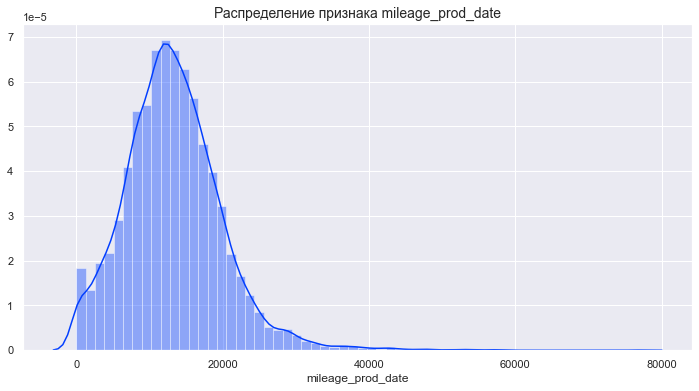

In [48]:
get_gr_num('mileage_prod_date', 60, 1)

### Пробег / кол-во владельцев
- Показывает сколько владелец в среднем проезжал на авто.

In [49]:
data['mileage_owns'] = data['mileage'] / data['Владельцы']
data['mileage_owns'] = data['mileage_owns'].astype('int64')

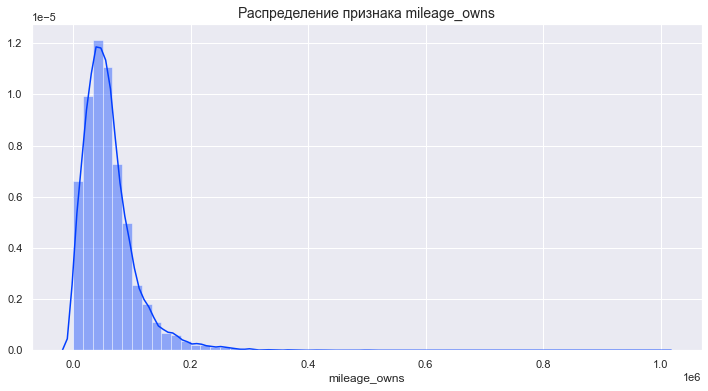

In [50]:
get_gr_num('mileage_owns', 60, 1)

### Среднее время владения автомобилем каждым владельцем

In [51]:
data['owns_year'] = (2021-data['productionDate']) / data['Владельцы']
data['owns_year'] = data['owns_year'].astype('int64')

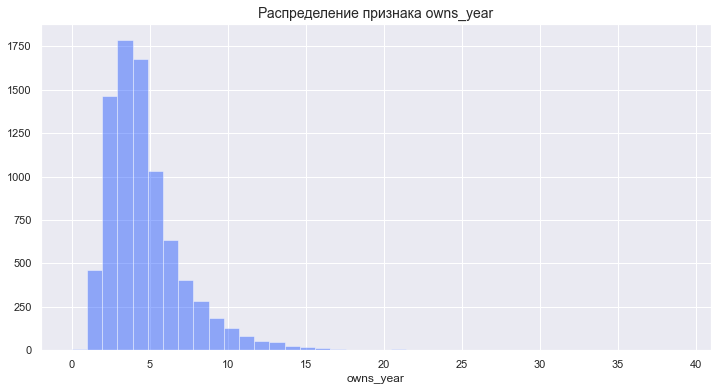

In [52]:
get_gr_num('owns_year', 40)

## Дублирование данных
Делаем на этом этапе, т. к. если делать в начале, возможны различия в признаках, которые в процессе EDA были удалены, а после всех преобразований различий в некоторых данных уже может не быть.

In [53]:
df_tmp = data.loc[:, data.columns != 'sell_id']
df_tmp[df_tmp.duplicated(keep=False)]

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,numberOfDoors,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,sample,price,model,xDrive,sDrive,CDI,AMG,BlueTEC,Long,длинный,4MATIC,BlueEfficiency,TRONIC,компактный,HYBRID,mileage_prod_date,mileage_owns,owns_year
4025,лифтбек,BMW,белый,320i задний 3ER бензин белый BMW лифтбек МБ-Бе...,2.0,184,бензин,82000,2015,3ER,5,2018,автоматическая,1,Оригинал,задний,1,1770000.0,320i,0,0,0,0,0,0,0,0,0,0,0,0,27333,82000,3
7206,лифтбек,BMW,белый,320i задний 3ER бензин белый BMW лифтбек МБ-Бе...,2.0,184,бензин,82000,2015,3ER,5,2018,автоматическая,1,Оригинал,задний,1,1770000.0,320i,0,0,0,0,0,0,0,0,0,0,0,0,27333,82000,3


- Найден один дубликат в тренировочном датасете. Удалим его.

In [54]:
data = data.drop(7206)

## Значимость признаков
Используем однофакторный дисперсионный анализ (ANOVA).

In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8350 entries, 0 to 8352
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             8350 non-null   object 
 1   brand                8350 non-null   object 
 2   color                8350 non-null   object 
 3   description          8350 non-null   object 
 4   engineDisplacement   8350 non-null   float64
 5   enginePower          8350 non-null   int64  
 6   fuelType             8350 non-null   object 
 7   mileage              8350 non-null   int64  
 8   modelDate            8350 non-null   int64  
 9   model_info           8350 non-null   object 
 10  numberOfDoors        8350 non-null   int64  
 11  productionDate       8350 non-null   int64  
 12  sell_id              8350 non-null   int64  
 13  vehicleTransmission  8350 non-null   object 
 14  Владельцы            8350 non-null   int64  
 15  ПТС                  8350 non-null   o

In [56]:
# Категориальные признаки
categorical_features = [
    'bodyType',
    'brand',
    'color',
    'fuelType',
    'model_info',
    'numberOfDoors',
    'vehicleTransmission',
    'Владельцы',
    'ПТС',
    'Привод',
    'model'
]

# Числовые признаки
numerical_features = [
    'engineDisplacement',
    'mileage',
    'modelDate',
    'mileage_prod_date',
    'mileage_owns',
    'owns_year',
    'productionDate',
    'enginePower'
]

Анализируем числовые признаки

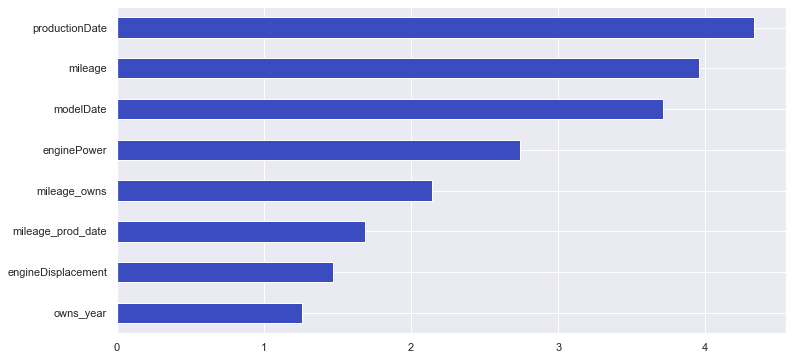

In [57]:
imp_num = pd.Series(f_classif(data[numerical_features], data['price'])[
                    0], index=numerical_features)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh', cmap='coolwarm');

**Предварительный вывод:**
- Самыми значимыми признаками, влияющими на цену, являются дата производства автомобиля и пробег.
- Можно использовать полученную информацию для проброса значимых признаков в Multiple inputs сетях.

## Обработка описаний для NLP-модели
### Очистка данных для NLP модели
- Стандартизация.
- Лемматизация.
- Стоп-слова.

####
- Переведем все слова в нижний регистр.
- Удалим из описаний всё, кроме букв и цифр.

In [58]:
data.description

0       300 задний W124 бензин чёрный MERCEDES универс...
1       640d полный 6ER дизель белый BMW купе Продаю л...
2       325xi полный 3ER бензин пурпурный BMW купе Маш...
3       318i задний 3ER бензин белый BMW седан Автомоб...
4       520d полный 5ER дизель чёрный BMW седан Немка!...
                              ...                        
8348    320i задний 3ER бензин серый BMW седан Продаёт...
8349    520d задний 5ER дизель чёрный BMW седан Куплен...
8350    318i задний 3ER бензин белый BMW седан Торг на...
8351    Long полный A8 бензин чёрный AUDI седан Автомо...
8352    Pullman задний S_KLASSE бензин чёрный MERCEDES...
Name: description, Length: 8350, dtype: object

In [59]:
data.description = data.description.str.lower()

pattern = '[^\w]'
data.description = data.description.apply(lambda x: re.sub(pattern, " ", x))

### Лемматизация и очистка от стоп-слов

In [60]:
print(stopwords.words('russian'))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

- Объединим тексты для более быстрой работы лемматизатора.
- Если недостаточно памяти, можно брать не все описания, а последовательно батчами (в нашем случае памяти достаточно для обработки сразу всех описаний).

In [61]:
%%time
data.description = data.description.apply(
    lambda x: x+'brbr ')  # Маркер для разъединения текстов

text_batch = ''
for text in data.description:
    text_batch += text

Wall time: 9.56 s


In [62]:
# Create lemmatizer and stopwords lists
mystem = Mystem()
russian_stopwords = stopwords.words('russian')

# Очистим описания от неинформативных слов
spec_stopwords = ['продавать', 'продаваться', 'привет', 'модель', 'двигатель', 'трансмиссия', 'цвет',
                  'кузов', 'салон', 'опция', 'машина', 'авто', 'автомобиль', 'день', 'покупатель', 'стоимость', 'купить', ' ']

# Объединим списки стоп-слов
main_stopwords = russian_stopwords + spec_stopwords

# Preprocess function
def preprocess_text(text):
    tokens = mystem.lemmatize(text)
    tokens = [token for token in tokens if token not in main_stopwords and token.strip()
              not in punctuation]
    text = " ".join(tokens)
    return text

In [63]:
%%time
text_batch = preprocess_text(text_batch).split('brbr')
del text_batch[-1]

Wall time: 45.2 s


In [64]:
data.description = text_batch

In [65]:
data.description

0       300 задний w124 бензин черный mercedes универс...
1        640d полный 6er дизель белый bmw купе любимый...
2        325xi полный 3er бензин пурпурный bmw купе пе...
3        318i задний 3er бензин белый bmw седан отличн...
4        520d полный 5er дизель черный bmw седан немка...
                              ...                        
8348     320i задний 3er бензин серый bmw седан любимы...
8349     520d задний 5er дизель черный bmw седан офици...
8350     318i задний 3er бензин белый bmw седан торг м...
8351     long полный a8 бензин черный audi седан отлич...
8352     pullman задний s klasse бензин черный mercede...
Name: description, Length: 8350, dtype: object

### Сохраним обработанный датасет

In [66]:
data.to_csv('data.csv', index=False)

## PreProc Tabular Data
### Подготовка датасетов для модели

In [68]:
def preproc_data(df_input):
    
    df_output = df_input.copy()
    
    # убираем не нужные для модели признаки
    df_output.drop(['description', 'sell_id'], axis = 1, inplace=True)

    # Логарифмирование
    for col in numerical_features:
        df_output[col] = np.log(df_output[col] + 1)
    df_output['price'] = np.log(df_output['price'] + 1)
        
    return df_output

In [69]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,numberOfDoors,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,sample,price,model,xDrive,sDrive,CDI,AMG,BlueTEC,Long,длинный,4MATIC,BlueEfficiency,TRONIC,компактный,HYBRID,mileage_prod_date,mileage_owns,owns_year
2684,внедорожник 5 дв.,BMW,серый,1.386294,5.323010,дизель,12.726169,7.602900,X3,5,7.603898,автоматическая,3,Дубликат,полный,1,13.122365,30d,0,0,0,0,0,0,0,0,0,0,0,0,9.953610,11.627557,1.791759
6385,универсал 5 дв.,BMW,чёрный,1.252763,5.389072,бензин,12.421188,7.603898,3ER,5,7.604894,автоматическая,3,Оригинал,полный,1,13.120363,325xi,0,0,0,0,0,0,0,0,0,0,0,0,9.782167,11.322576,1.609438
5893,внедорожник 5 дв.,BMW,серый,1.098612,5.017280,дизель,10.243987,7.608871,X1,5,7.609862,автоматическая,1,Оригинал,полный,1,14.452088,18d,1,0,0,0,0,0,0,0,0,0,0,0,8.857800,10.243987,1.609438
6360,внедорожник 5 дв.,MERCEDES,чёрный,1.871802,5.963579,бензин,11.728045,7.604396,GL_KLASSE,5,7.605392,автоматическая,3,Оригинал,полный,1,13.652993,500,0,0,0,0,0,0,0,0,0,0,0,0,9.163144,10.629441,1.609438
5376,седан,BMW,белый,1.098612,5.220356,бензин,11.826356,7.606885,3ER,4,7.607878,автоматическая,2,Оригинал,задний,1,14.038655,320i,0,0,0,0,0,0,0,0,0,0,0,0,9.746951,11.133216,1.609438
5770,седан,BMW,чёрный,1.335001,5.267858,бензин,12.840414,7.600402,7ER,4,7.600402,автоматическая,3,Дубликат,задний,1,12.821261,728Li,0,0,0,0,0,0,0,0,0,0,0,0,9.704976,11.741805,2.079442
1480,внедорожник 5 дв.,MERCEDES,синий,1.098612,5.273000,дизель,9.417436,7.610853,GLC_COUPE,5,7.610853,автоматическая,1,Оригинал,полный,0,0.000000,220,0,0,0,0,0,0,0,0,0,0,0,0,8.724370,9.417436,1.098612
6350,внедорожник 5 дв.,MERCEDES,чёрный,1.098612,5.356586,бензин,10.576458,7.607878,GLA_CLASS,5,7.609367,роботизированная,1,Оригинал,полный,1,14.346139,250,0,0,0,0,0,0,0,0,0,0,0,0,8.967122,10.576458,1.791759
1595,внедорожник 5 дв.,AUDI,белый,1.098612,5.141664,бензин,11.814037,7.606885,Q3,5,7.607878,роботизированная,1,Оригинал,полный,0,0.000000,2.0,0,0,0,0,0,0,0,0,0,0,0,0,9.734595,11.814037,2.197225
7942,внедорожник 5 дв.,BMW,чёрный,1.386294,5.726848,бензин,11.277216,7.604894,X6,5,7.606387,автоматическая,2,Оригинал,полный,1,14.115616,35i,0,0,0,0,0,0,0,0,0,0,0,0,8.879333,10.584081,1.791759


In [70]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8350 entries, 0 to 8352
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             8350 non-null   object 
 1   brand                8350 non-null   object 
 2   color                8350 non-null   object 
 3   engineDisplacement   8350 non-null   float64
 4   enginePower          8350 non-null   float64
 5   fuelType             8350 non-null   object 
 6   mileage              8350 non-null   float64
 7   modelDate            8350 non-null   float64
 8   model_info           8350 non-null   object 
 9   numberOfDoors        8350 non-null   int64  
 10  productionDate       8350 non-null   float64
 11  vehicleTransmission  8350 non-null   object 
 12  Владельцы            8350 non-null   int64  
 13  ПТС                  8350 non-null   object 
 14  Привод               8350 non-null   object 
 15  sample               8350 non-null   i

### Split data

In [71]:
# Выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

## Model 2: CatBoostRegressor

In [72]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [73]:
model = CatBoostRegressor(iterations=8000,
                          random_seed=RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          )

model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          cat_features=categorical_features,
          verbose_eval=100,
          use_best_model=True,
          plot=False
          )

Learning rate set to 0.017514
0:	learn: 0.0422648	test: 0.0409910	best: 0.0409910 (0)	total: 104ms	remaining: 13m 50s
100:	learn: 0.0152878	test: 0.0154830	best: 0.0154830 (100)	total: 2.86s	remaining: 3m 43s
200:	learn: 0.0112166	test: 0.0115056	best: 0.0115056 (200)	total: 5.54s	remaining: 3m 35s
300:	learn: 0.0102888	test: 0.0106854	best: 0.0106854 (300)	total: 8.26s	remaining: 3m 31s
400:	learn: 0.0098119	test: 0.0102819	best: 0.0102819 (400)	total: 10.9s	remaining: 3m 26s
500:	learn: 0.0094495	test: 0.0099753	best: 0.0099753 (500)	total: 13.5s	remaining: 3m 22s
600:	learn: 0.0091143	test: 0.0096928	best: 0.0096928 (600)	total: 16.2s	remaining: 3m 19s
700:	learn: 0.0088309	test: 0.0094953	best: 0.0094953 (700)	total: 18.9s	remaining: 3m 16s
800:	learn: 0.0085785	test: 0.0093242	best: 0.0093242 (800)	total: 21.5s	remaining: 3m 13s
900:	learn: 0.0083639	test: 0.0091690	best: 0.0091690 (900)	total: 24.2s	remaining: 3m 10s
1000:	learn: 0.0081910	test: 0.0090613	best: 0.0090613 (1000)	t

### Submission

In [74]:
sub_predict_catboost = model.predict(X_sub)
sub_predict_catboost = np.exp(sub_predict_catboost)

sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv(r'csv/without_round_catboost.csv', index=False)

# округлим
sub_predict_catboost = (sub_predict_catboost // 1000) * 1000

sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv(r'csv/catboost_submission.csv', index=False)

## Выводы по части 1:
- Построена "наивная" модель для задания начального ориентира по метрики.
- Точность "наивной" модели по метрике MAPE: 19.88%.
- Проведен анализ и обработка признаков.
- Сгенерированы новые признаки (feature engineering).
- Проведена оценка значимости признаков.
- Обработаны текстовые описания для передачи в NLP-модель (очистка, нормализация, лемматизация, удаление стоп-слов).
- Проведена нормализация и логарифмирование числовых признаков.
- Протестирована и настроена ML модель CatBoostRegressor.
- Точность CatBoostRegressor модели по метрике MAPE: 11.87%.